In this analysis, we will explore a dataset of google job ads. Those ads correspond either to the search string `machine learning engineer` or `data scientist`.

In [1]:
import os
import io
import re
import yaml

import pandas as pd
import numpy as np

from stemming import porter2

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_validate, GridSearchCV, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn import set_config


import matplotlib as mlib
import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import storage

In [2]:
set_config(display='diagram')

In [3]:
config_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'config.yaml'))
with open(config_path, 'r') as config_file:
    config = yaml.load(config_file, Loader=yaml.SafeLoader)

In [4]:
%matplotlib inline

In [5]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.dpi']= 180

In [6]:
client = storage.Client(config['project'])
bucket = client.get_bucket(config['bucket'])
blob = bucket.blob(config['dest_file'])
file_content = io.BytesIO(blob.download_as_string())

ads = pd.read_csv(file_content)

/Users/ruslan.kozhuharov/venvs/tf/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [7]:
ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 7 columns):
id                  567 non-null object
job_descr           565 non-null object
location            561 non-null object
minimum_qual        565 non-null object
preferred_qual      565 non-null object
responsibilities    565 non-null object
title               567 non-null object
dtypes: object(7)
memory usage: 31.1+ KB


First, let us try using simple string operations to derive the additional information from the job title. Such information could be: seniority, function, etc.

In [8]:
ads.fillna('unknown', inplace=True)

In [9]:
ads[['role', 'department', 'area', 'other']] = ads.title.str.split(',', expand=True)

In [10]:
seniority_re = r'.*(intern|senior|lead|staff|principal|manager|head).*'
function_re = r'.*(engineer|scientist|science|consultant|architect|advocate|developer|analyst|specialist).*'

ads['seniority'] = ads.role.str.extract(pat=seniority_re, flags=re.I).fillna('L3-L4')[0].str.lower()
ads['function'] = (ads.role.str.extract(pat=function_re, flags=re.I)[0]
                   .str.lower().str.replace('science', 'scientist', flags=re.I))

In [11]:
ads[['title', 'role', 'department', 'area', 'seniority', 'function']].head()

,title,role,department,area,seniority,function
0,"Cloud AI Engineer, Professional Services",Cloud AI Engineer,Professional Services,None,l3-l4,engineer
1,"Cloud AI Engineer, Professional Services",Cloud AI Engineer,Professional Services,None,l3-l4,engineer
2,"Conversational AI Engineer, Google Cloud Profe...",Conversational AI Engineer,Google Cloud Professional Services,None,l3-l4,engineer
3,"Cloud AI Engineer, Professional Services",Cloud AI Engineer,Professional Services,None,l3-l4,engineer
4,"Data Scientist, Engineering",Data Scientist,Engineering,None,l3-l4,scientist


An interesting insight could be to see the most relevant terms from the qualifications and responsibilities with regards to the function. This could give us an isight into the keywords that one should emphasize on in their resume.

In [12]:
ads.seniority.value_counts()

l3-l4        377
staff         58
senior        39
intern        35
lead          27
manager       22
principal      8
head           1
Name: seniority, dtype: int64

In [13]:
ads.location.value_counts()

Mountain View       93
Sunnyvale           53
Bengaluru           36
Xindian District    23
Warsaw              21
                    ..
Hamburg              1
Helsinki             1
Santa Barbara        1
Brussels             1
Addison              1
Name: location, Length: 68, dtype: int64

In [14]:
ads.function.value_counts()

engineer      380
architect      74
developer      18
scientist      16
analyst        11
consultant     11
specialist      3
advocate        2
Name: function, dtype: int64

In [15]:
to_model = ads[ads.function.isin(['engineer', 'scientist', 'architect'])].copy()

In [16]:
label_enc = LabelEncoder()
to_model['function_enc'] = label_enc.fit_transform(to_model.function.astype('str'))

In [46]:
tfidf_params = {'stop_words':'english',
                'ngram_range':(2, 5),
                'strip_accents':'unicode'}

text_cols = ['job_descr', 'minimum_qual', 'preferred_qual', 'responsibilities']

column_trans = ColumnTransformer([(f'tfidf_{c}', TfidfVectorizer(**tfidf_params), c) for c in text_cols])

multi_col_pipe = Pipeline([('multi_col_tfidf', column_trans),
                           ('naive_bayes_clf', MultinomialNB())])

In [47]:
X = to_model.drop('function_enc', axis=1)
y = to_model.function_enc

In [48]:
model = multi_col_pipe.fit(X, y)

In [49]:
model

Pipeline(steps=[('multi_col_tfidf',
                 ColumnTransformer(transformers=[('tfidf_job_descr',
                                                  TfidfVectorizer(ngram_range=(2,
                                                                               5),
                                                                  stop_words='english',
                                                                  strip_accents='unicode'),
                                                  'job_descr'),
                                                 ('tfidf_minimum_qual',
                                                  TfidfVectorizer(ngram_range=(2,
                                                                               5),
                                                                  stop_words='english',
                                                                  strip_accents='unicode'),
                                                  'minimum_qual'),
                                                 ('tfidf_preferred_qual',
                                                  TfidfVectorizer(ngram_range=(2,
                                                                               5),
                                                                  stop_words='english',
                                                                  strip_accents='unicode'),
                                                  'preferred_qual'),
                                                 ('tfidf_responsibilities',
                                                  TfidfVectorizer(ngram_range=(2,
                                                                               5),
                                                                  stop_words='english',
                                                                  strip_accents='unicode'),
                                                  'responsibilities')])),
                ('naive_bayes_clf', MultinomialNB())])

In [50]:
scores = cross_validate(model, X, y, cv=3, scoring='f1_weighted', return_train_score=True)

In [51]:
for k in scores.keys():
    print(f'{k}, mean: {scores[k].mean():.2f}, std: {scores[k].std():.2f}')

fit_time, mean: 0.58, std: 0.02
score_time, mean: 0.21, std: 0.01
test_score, mean: 0.88, std: 0.03
train_score, mean: 0.98, std: 0.01


In [52]:
steps = 100

lc_res = learning_curve(model, X, y, cv=3, train_sizes=np.linspace(0.1, 1.0, steps), scoring='f1_weighted', n_jobs=6, random_state=42)

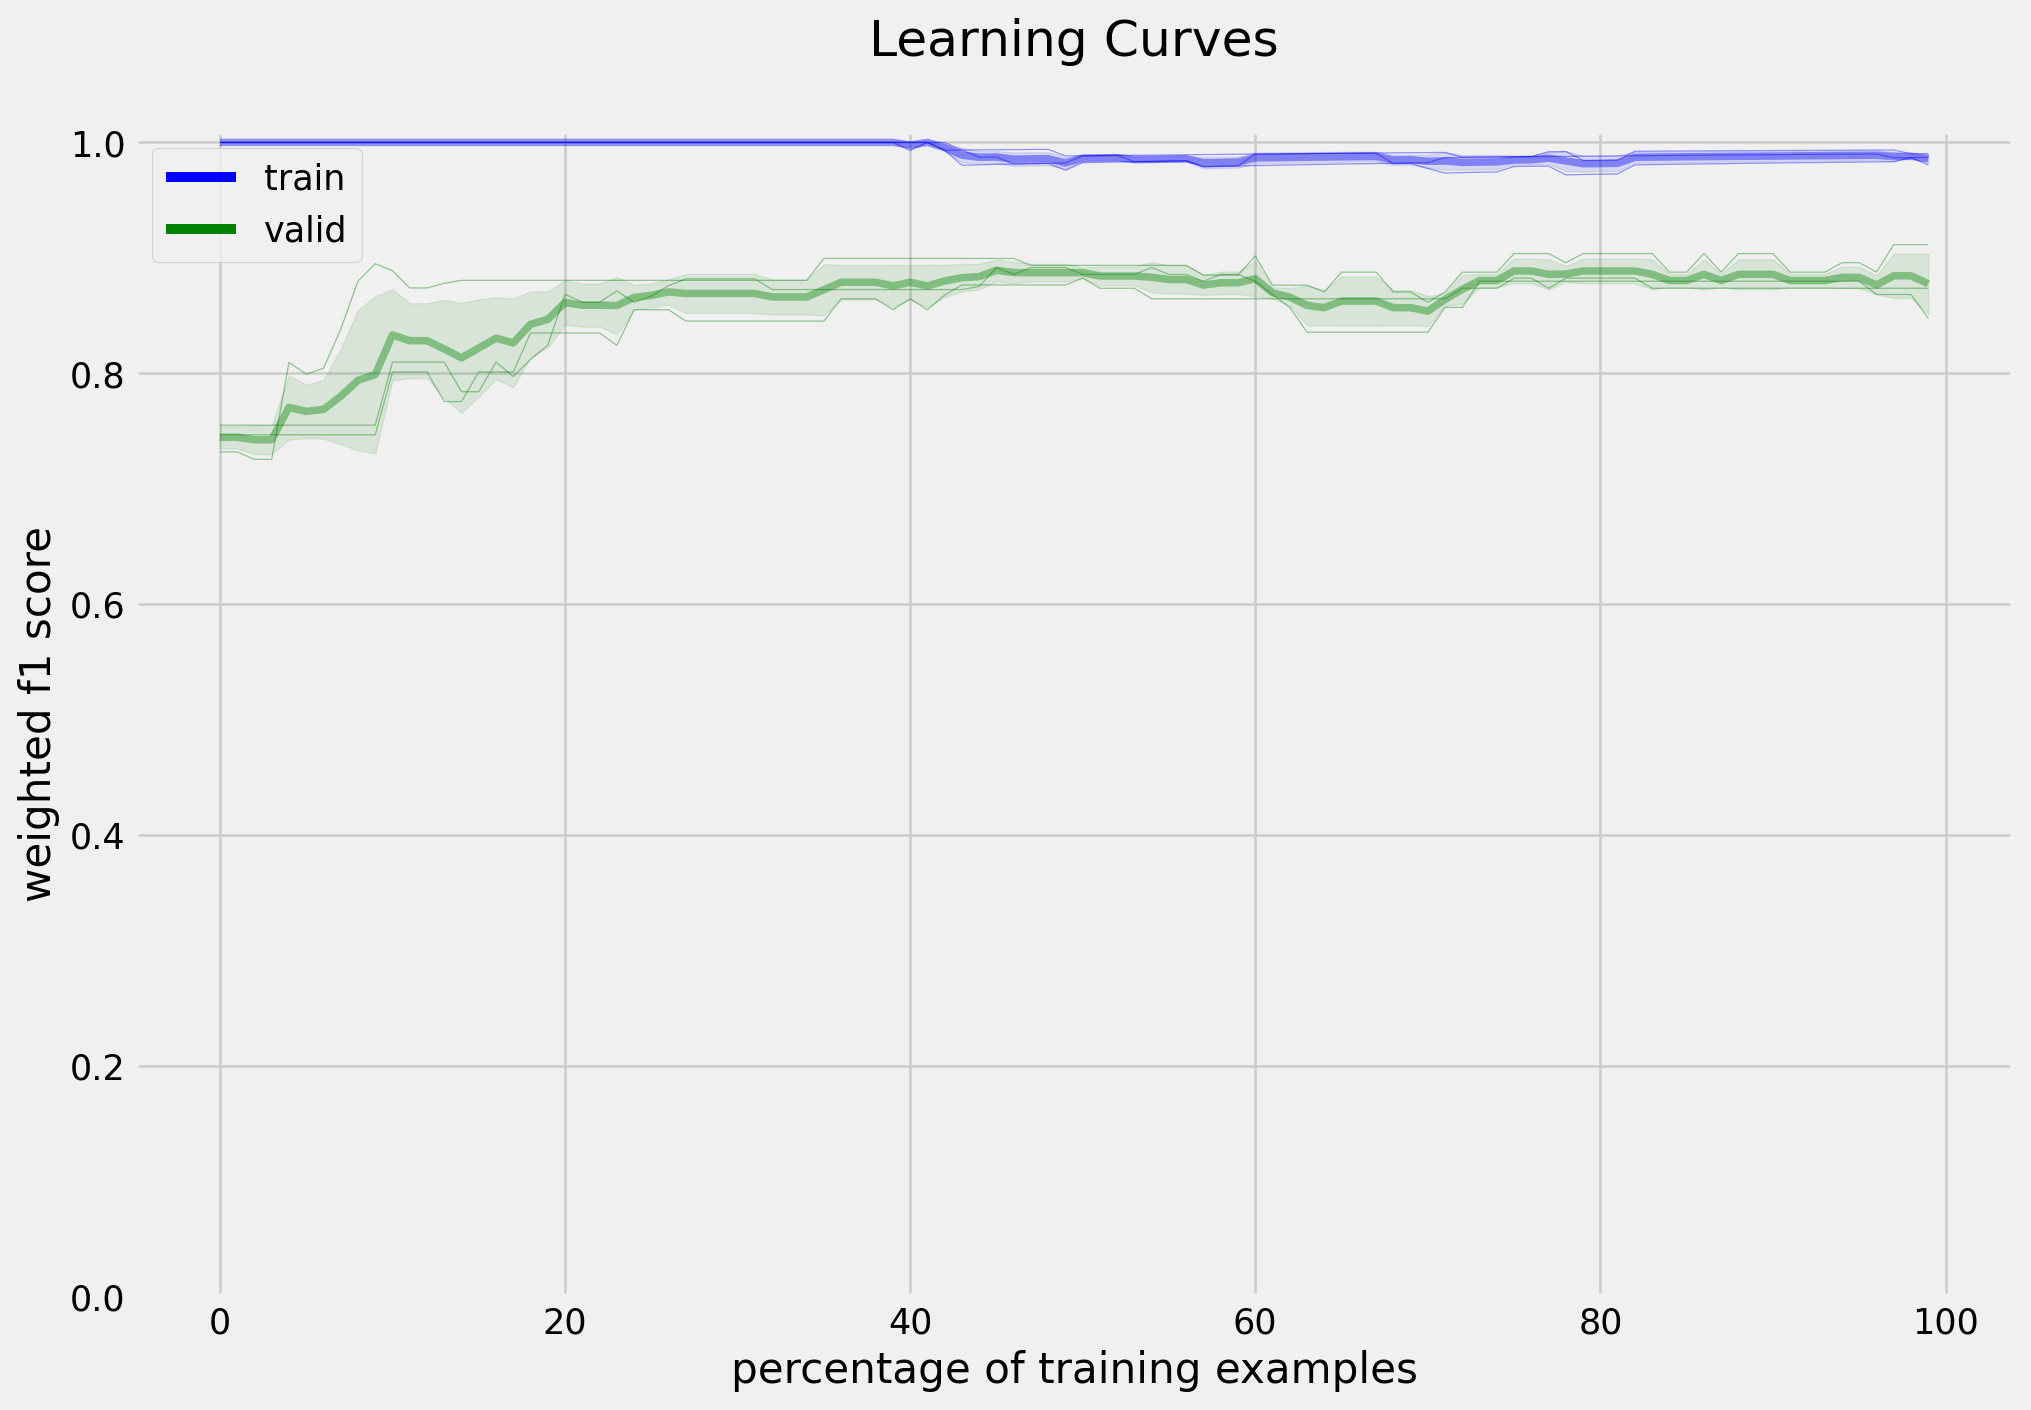

In [53]:
fig=plt.figure(figsize=(12, 8))

legend_handles = []

for i, c, l in zip([1, 2], ['b', 'g'], ['train', 'valid']):
    scores = lc_res[i]
    mean = np.mean(scores, axis=1)
    std = np.std(scores, axis=1)
    
    plt.fill_between(range(0, steps), mean-std, mean+std, color=c, alpha=0.1)
    plt.plot(mean, c=c, linewidth=3, alpha=0.4)
    legend_handles.append(mlib.lines.Line2D([], [], color=c, label=l))
    
    for j in range(3):
        plt.plot(scores[:, j], c=c, linewidth=0.5, alpha=0.4)

plt.ylim(0, 1.01)
plt.legend(handles=legend_handles)
plt.ylabel('weighted f1 score')
plt.xlabel('percentage of training examples')
plt.title('Learning Curves', pad=30)
plt.show()

In [54]:
importances_mcp = pd.DataFrame(model['naive_bayes_clf'].feature_log_prob_.transpose(),
                               columns=label_enc.classes_,
                               index=model['multi_col_tfidf'].get_feature_names())

In [55]:
col_prefix = re.compile('(' + '|'.join([f'tfidf_{c}' for c in text_cols]) + ')(__)(.*)')

In [56]:
top_n = 50
imp_terms = pd.DataFrame()

for l in label_enc.classes_:
    imp_label = importances_mcp[l].sort_values(ascending=False)[:top_n]
    to_append = [{'feature': col_prefix.match(feature_term)[1],
                  'term': col_prefix.match(feature_term)[3],
                  'importance': imp,
                  'label': l}
                 for feature_term, imp in zip(imp_label.index, imp_label.values)]
    imp_terms = imp_terms.append(to_append, ignore_index=True)

In [59]:
imp_terms.sort_values('importance').head()

,feature,term,importance,label
149,tfidf_preferred_qual,statistics computer science,-11.646266,scientist
148,tfidf_preferred_qual,statistics computer,-11.646266,scientist
145,tfidf_preferred_qual,phd statistics computer science,-11.646266,scientist
146,tfidf_preferred_qual,phd statistics,-11.646266,scientist
147,tfidf_preferred_qual,phd statistics computer,-11.646266,scientist


In [60]:
to_crosstab = imp_terms[imp_terms.label=='scientist']

pd.crosstab(to_crosstab.term, to_crosstab.feature).head()

feature,tfidf_job_descr,tfidf_minimum_qual,tfidf_preferred_qual
term,,,
data analysis,0,0,1
data scientist,0,1,0
database languages,0,1,0
database languages sql,0,1,0
degree quantitative,0,1,0
